# Convolution setting up

## Functions definition

In [2]:
# Function taking the interval [a, b] where some (b-a)-periodic function is defined and returns x shifted into this interval
function center_arg(a,b,x)
    M = floor((x-a)/(b-a))
    x -= M*(b-a)
    return x
end

center_arg (generic function with 1 method)

In [3]:
# Defining book's kernel function

function f(x)
    # Scaling the input argument to get a periodic function
    x = center_arg(0, 1, x)
    if 0.1<=x<=0.2
        return 5x-0.5
    elseif 0.2<x<=0.3
        return -5x+1.5
    elseif 0.5<x<=0.6
        return 1 
    elseif 0.6<x<0.7
        return 0.2 
    elseif 0.7<=x<=0.8
        return 1.3
    else 
        return 0
    end
end

f (generic function with 1 method)

1001


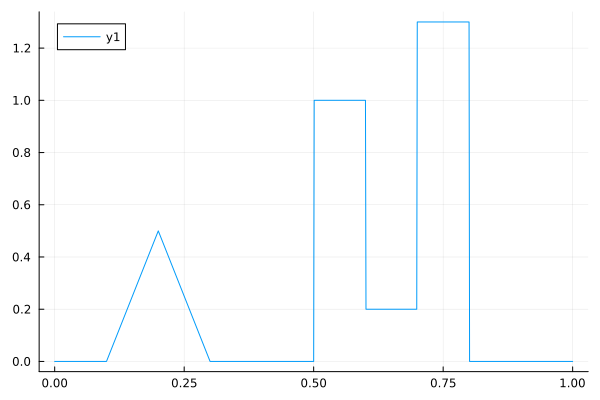

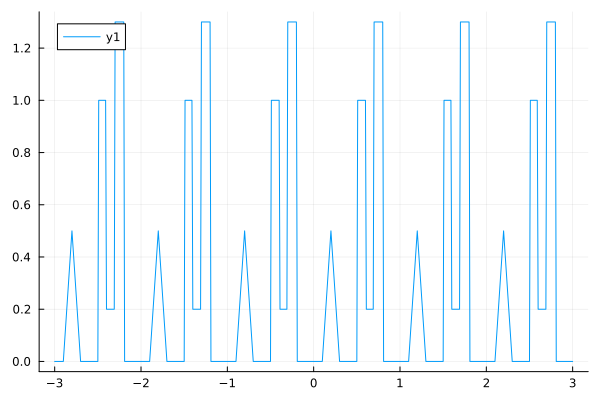

In [4]:
using Plots

dx = 0.001
X = 0:dx:1
N = length(X)
println(N)

# Plotting kernel on [0,1] then on [-3,3] to see the periodicity
display(plot(X, f.(X)))
plot(-3:0.01:3, f.(-3:0.01:3))

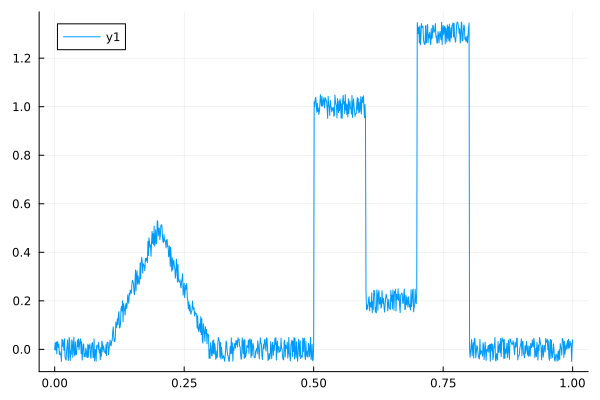

In [5]:
## Introducing noise
σ = 0.1 # noise level
noise(x) = (rand()-0.5)*σ # uniform noise in [-σ/2, σ/2]
f_noise(x) = f(x) + noise(x)
plot(X, f_noise.(X))


1.0666666666666666e-10


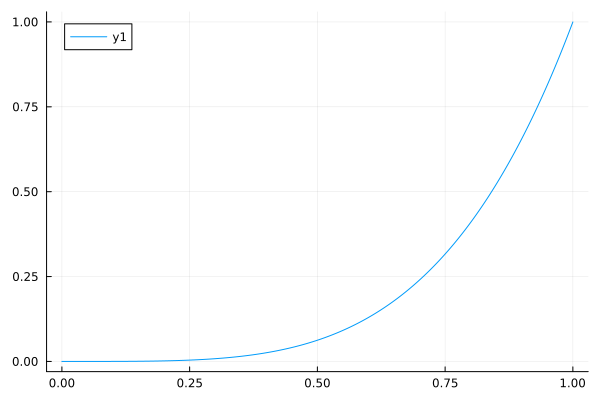

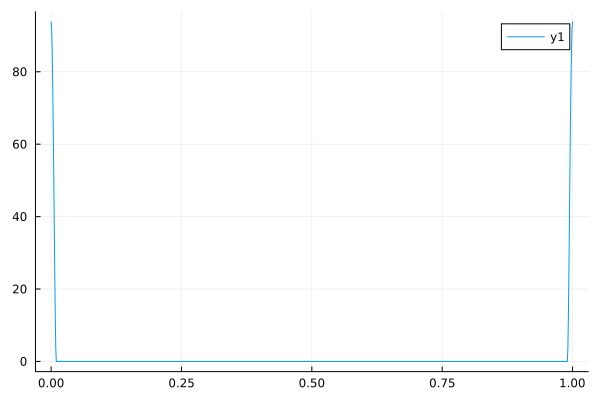

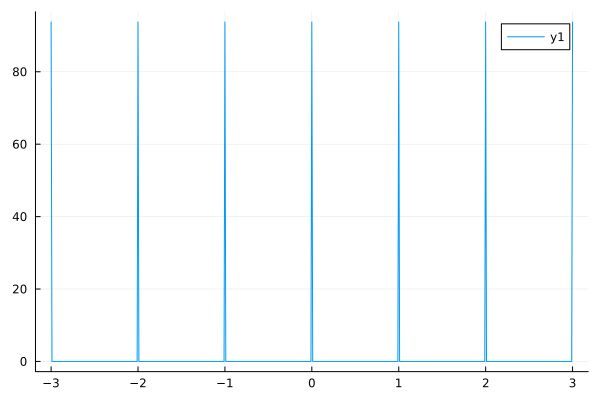

In [21]:
using QuadGK

# Point spread function (PSF)
a = 0.01
p(x) = (x+a)^2*(x-a)^2
C,_ = quadgk(p,-a,a) 
println(C)

function psf(x,a)
    x = center_arg(-.5, .5, x)
    # a > 0
    res = 0
    if -a <= x <= a
        res = (p(x)/C)
    end
    return res
end

# Plotting PSF generation function, then the PSF itself
display(plot(X, p.(X)))
display(plot(X, psf.(X,a)))
plot(-3:0.01:3, psf.(-3:0.01:3, a))


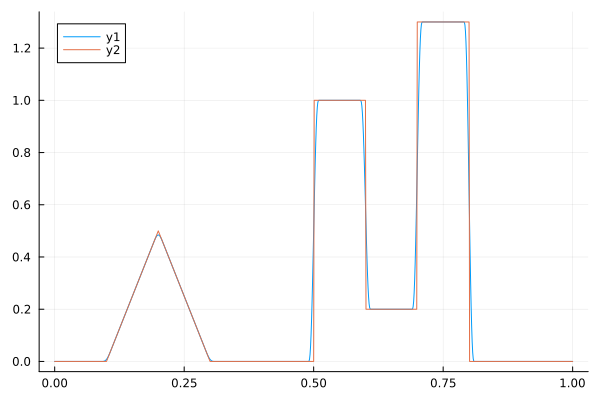

In [22]:
# Convolution
function convolved(s)
    K(t) = f(s-t) * psf(t,a)
    res, _ = quadgk(K, -a, a)
    return(res)
end

plot(X, [convolved.(X),f.(X)])

# Chapter 1 & 2

## Naïve reconstruction

#### Naïve reconstruction

In [23]:
A = zeros(N,N)
ν = floor(Int, a/dx)
P = psf.((-ν:ν)*dx,a)
for i in 1:N
    for j in -ν:ν
        A[i,1+mod(i+j-1,N)] = dx * P[ν+1-j]
    end
end
println(ν)
println(P)
println(P[ν+1])
A

10
[0.0, 3.3843750000000066, 12.150000000000004, 24.384375000000006, 38.4, 52.734375, 66.15000000000002, 77.63437500000003, 86.4, 91.88437500000002, 93.75000000000001, 91.88437500000002, 86.4, 77.63437500000003, 66.15000000000002, 52.734375, 38.4, 24.384375000000006, 12.150000000000004, 3.3843750000000066, 0.0]
93.75000000000001


1001×1001 Matrix{Float64}:
 0.09375     0.0918844   0.0864      …  0.0776344   0.0864      0.0918844
 0.0918844   0.09375     0.0918844      0.06615     0.0776344   0.0864
 0.0864      0.0918844   0.09375        0.0527344   0.06615     0.0776344
 0.0776344   0.0864      0.0918844      0.0384      0.0527344   0.06615
 0.06615     0.0776344   0.0864         0.0243844   0.0384      0.0527344
 0.0527344   0.06615     0.0776344   …  0.01215     0.0243844   0.0384
 0.0384      0.0527344   0.06615        0.00338438  0.01215     0.0243844
 0.0243844   0.0384      0.0527344      0.0         0.00338438  0.01215
 0.01215     0.0243844   0.0384         0.0         0.0         0.00338438
 0.00338438  0.01215     0.0243844      0.0         0.0         0.0
 ⋮                                   ⋱                          ⋮
 0.00338438  0.0         0.0            0.0384      0.0243844   0.01215
 0.01215     0.00338438  0.0            0.0527344   0.0384      0.0243844
 0.0243844   0.01215     0.00338438 

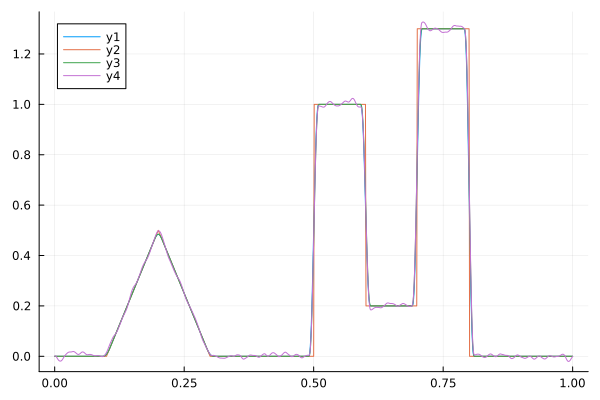

In [24]:
# Approximation of f
convolved_scat = A * f.(X)
convolved_scat_noise = A * f_noise.(X)

plot(X, [convolved.(X),f.(X), convolved_scat, convolved_scat_noise])


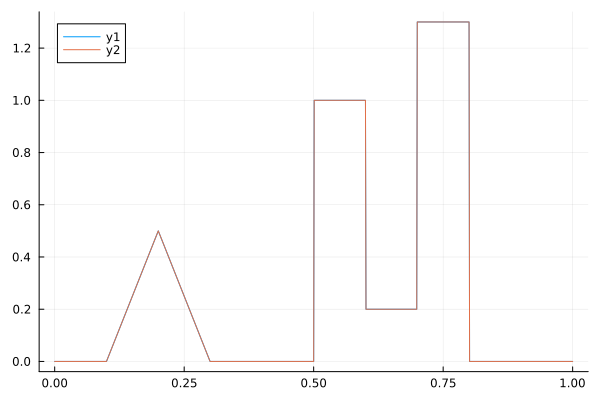

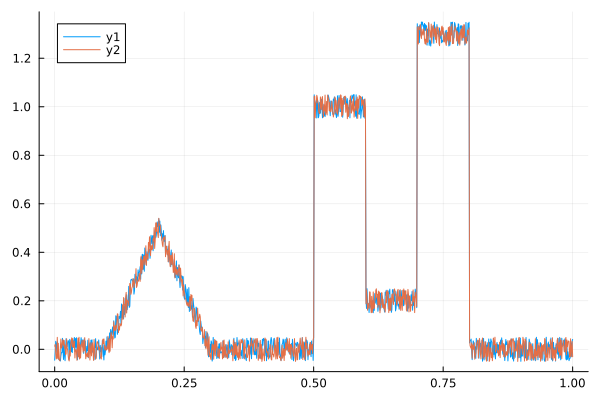

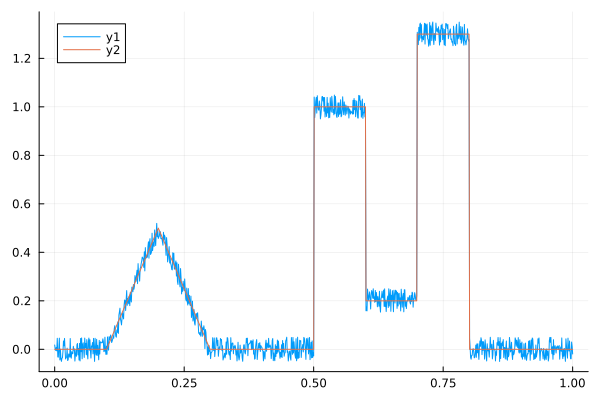

In [25]:
f_inverse = A^-1 * convolved_scat
f_noise_inverse = A^-1 * convolved_scat_noise
f_inverse_noised = A^-1 * convolved_scat + noise.(X)

display(plot(X, [f_inverse, f.(X)]))
display(plot(X, [f_noise_inverse, f_noise.(X)]))
plot(X, [f_inverse_noised, f.(X)])

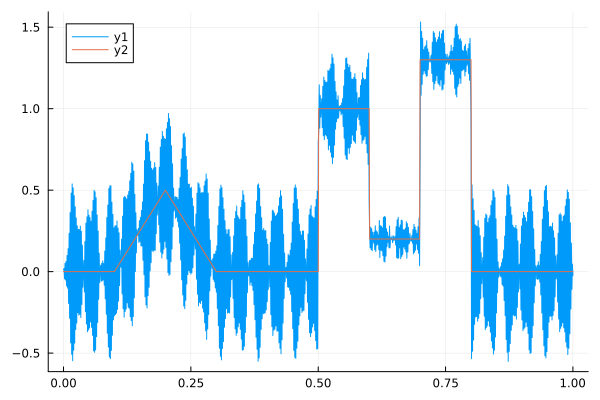

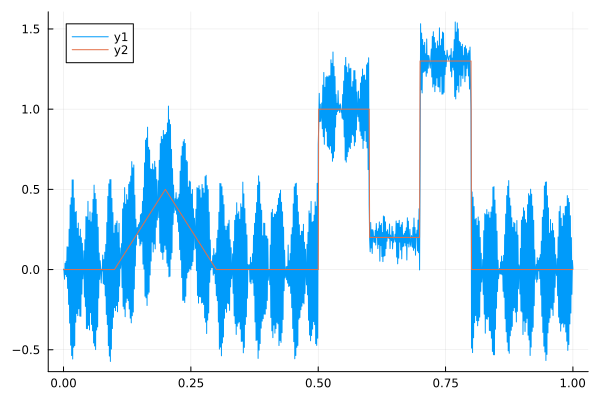

In [26]:
f_inverse_realconvol = A^-1 * convolved.(X)
f_inverse_noised_realconvol = A^-1 * convolved.(X) + noise.(X)

display(plot(X, [f_inverse_realconvol, f.(X)]))
plot(X, [f_inverse_noised_realconvol, f.(X)])

# Chapters 3 and 4

## Noise robustness 

Exercise 4.4.2 example

Conditionnement : 321032.55319339357


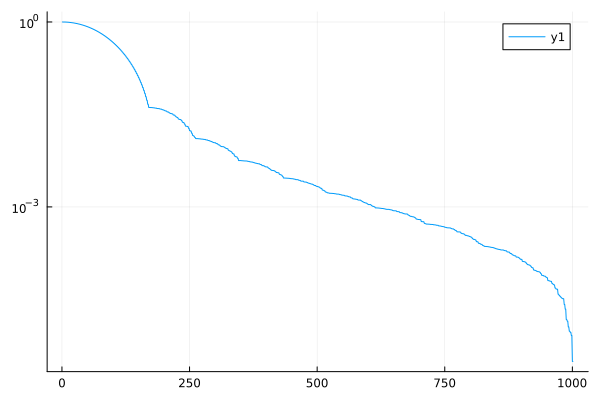

In [27]:
using LinearAlgebra

A_svd = svd(A)
D = A_svd.S
println("Conditionnement : ", maximum(D)/minimum(D))
# Plotting the singular values in decreasing order
plot(D, yaxis=:log)


In [28]:
# Defining TSVD Regularization matrices

function D⁺(D,α)
    n = length(D)
    D⁺ = zeros(n)
    for i = 1:n
        if D[i] > α
            D⁺[i] = 1/D[i]
        end
    end
    return D⁺
end

function D_TSVD(D, n_sval)
    n = length(D)
    res = zeros(n)
    for i = 1:n_sval
        res[i] = 1/D[i]
    end
    return res
end


D_TSVD (generic function with 1 method)

In [29]:
# One can define the Regularization matrix by either choosing the threshold on singular value α or by choosing the trucation index n_sval
α = 1e-3
n_sval = 200
#inv = A_svd.V * Diagonal(D⁺(A_svd.S, α)) * A_svd.U'
inv = A_svd.V * Diagonal(D_TSVD(A_svd.S, n_sval)) * A_svd.U'

1001×1001 Matrix{Float64}:
 -0.116555    0.0047609   0.295866   …   0.576408    0.295866    0.0047609
  0.0047609  -0.0915954   0.0413896      0.625088    0.53978     0.270906
  0.295866    0.0413896  -0.0628014      0.38585     0.600129    0.53978
  0.576408    0.32466     0.0470169     -0.0815061   0.38585     0.625088
  0.653882    0.582036    0.304124      -0.591645   -0.0565466   0.422478
  0.428106    0.633347    0.546271   …  -0.916762   -0.555016   -0.0277526
 -0.0482883   0.392342    0.601398      -0.894531   -0.887968   -0.549389
 -0.585153   -0.0802373   0.38122       -0.509117   -0.888904   -0.908503
 -0.940452   -0.596275   -0.06461        0.0943395  -0.529653   -0.924668
 -0.93579    -0.924825   -0.562219       0.669973    0.0585754  -0.561602
  ⋮                                  ⋱                           ⋮
 -0.93579    -0.561602    0.0585754     -0.0302601  -0.562219   -0.924825
 -0.940452   -0.924668   -0.529653       0.415275   -0.06461    -0.596275
 -0.585153   -0.9

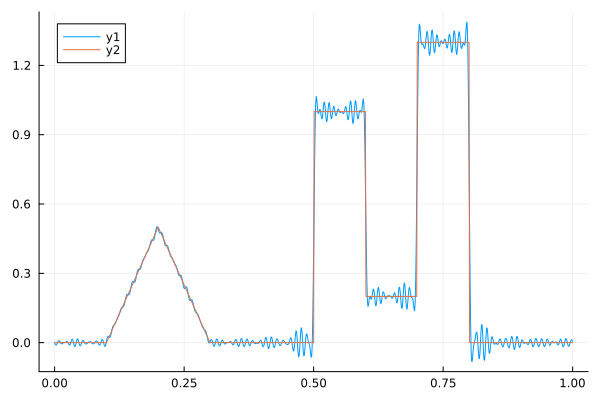

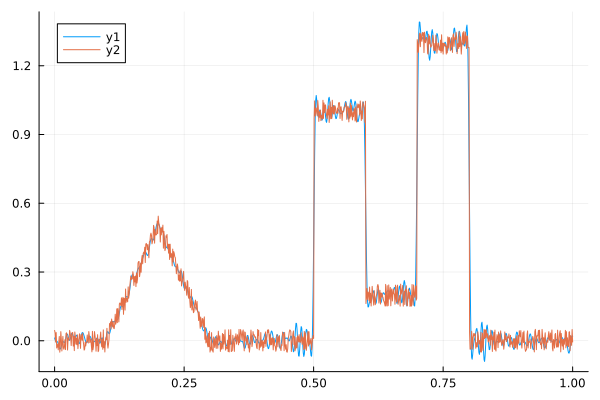

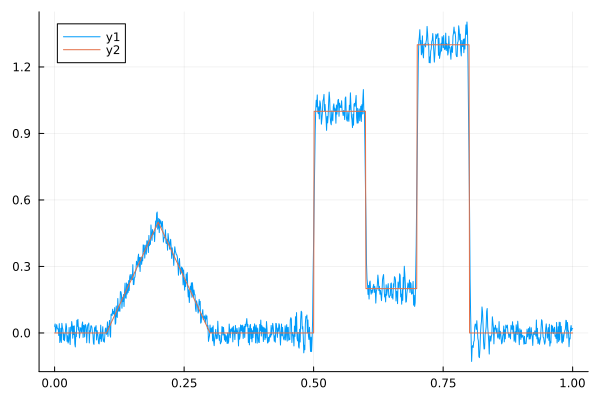

In [30]:
f_inverse = inv * convolved_scat
f_noise_inverse = inv * convolved_scat_noise
f_inverse_noised = inv * convolved_scat + noise.(X)

display(plot(X, [f_inverse, f.(X)]))
display(plot(X, [f_noise_inverse, f_noise.(X)]))
plot(X, [f_inverse_noised, f.(X)])

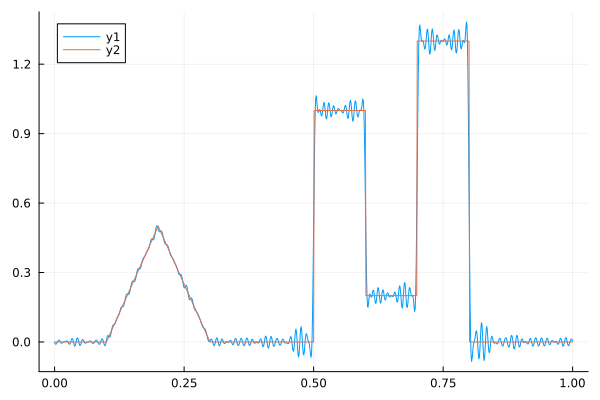

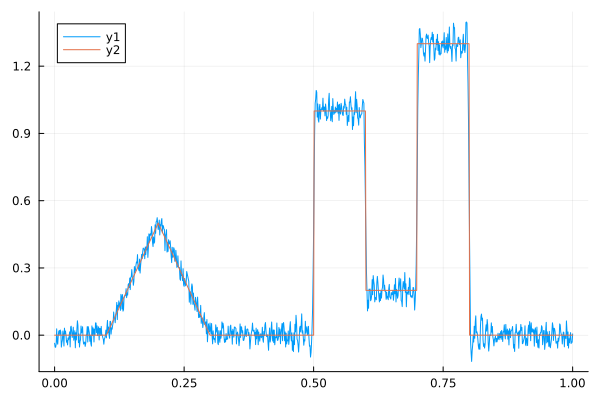

In [31]:
f_inverse_realconvol = inv * convolved.(X)
f_inverse_noised_realconvol = inv * convolved.(X) + noise.(X)

display(plot(X, [f_inverse_realconvol, f.(X)]))
plot(X, [f_inverse_noised_realconvol, f.(X)])

# Chapter 6 :  Total variation Regularization

### Exercice 6.6.1

Norm 1 and 2 of Lof : [80.0, 391.5478696387713]
Norm 1 and 2 of Loh : [80.0, 1600.0]


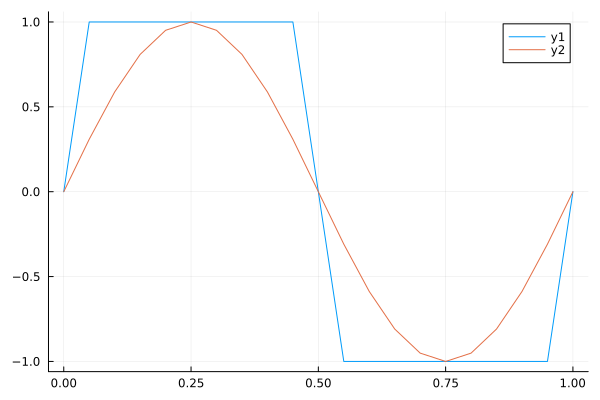

In [32]:
using Plots

stp = 1/20
rng = 0:stp:1
function h(x)
    res = 0.
    if 0 < x < 0.5
        res = 1.
    elseif 0.5 < x < 1
        res = -1.
    end
    return res
end
wv(x) = sin(2 * π * x)

norm1(Z, step) = sum(abs.(Z[2:end]-Z[1:end-1])/step)
norm2(Z,step)= sum((abs.(Z[2:end]-Z[1:end-1])/step).^2)

# Comparison of the different norms
println("Norm 1 and 2 of Lof : ", [norm1(wv.(rng), stp), norm2(wv.(rng), stp)])
println("Norm 1 and 2 of Loh : ", [norm1(h.(rng), stp), norm2(h.(rng), stp)])


plot(rng, [h.(rng), wv.(rng)])

In [33]:
function L(ds,n)
    res = zeros(n,n)
    for i in 1:n-1
        for j in i:i+1
            res[i,j] = i==j ? 1 : -1
        end
    end
    res[n,n] = 1
    res[n,1] = -1
    return 1/ds * res            
end

# Lmat = L(1/10,10)

L (generic function with 1 method)

In [34]:
using JuMP, Clarabel, SparseArrays

function totalVar(A, m, α, ds)
    n = size(A,2)
    Lmat = L(ds, n)
    H = zeros(3n, 3n)
    H[1:n, 1:n] = 2*A'*A
    h = vcat(- 2*A'*m, α * ones(n), α * ones(n))

    Eq = hcat(Lmat, -I(n), I(n))
    b = zeros(n)

    model = Model(Clarabel.Optimizer)
    @variable(model, y[1:3n] >= 0)
    @variable(model, t[1:1])
    @constraint(model, [t[1]; h + H * y] in SecondOrderCone())
    # @constraint(model, [t[2]; Lmat*y[1:n]] in FirstOrderCone())
    @constraint(model, y[n+1:3n] .>= 0) # Non-negativity constraint
    @constraint(model, Eq*y == b) # Equality constraint
    @objective(model, Min, t[1]) # + α * t[2]) --- IGNORE ---
    optimize!(model)
    @assert is_solved_and_feasible(model)
    return value.(y[1:n])
end

αs = [0.005, 0.05, 0.1, 1, 10]
f_TVs = []
for α in αs
    println("Solving for α = $α")
    push!(f_TVs,totalVar(A,convolved_scat, α, 0.001))
end
print("solved")


Solving for α = 0.005
-------------------------------------------------------------
           Clarabel.jl v0.7.1  -  Clever Acronym              
                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 3004
  constraints   = 9010
  nnz(P)        = 0
  nnz(A)        = 46047
  cones (total) = 4
    : Zero        = 1,  numel = 1001
    : Nonnegative = 2,  numel = (3003,2002)
    : SecondOrder = 1,  numel = 3004

settings:
  linear algebra: direct / qdldl, precision: Float64
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-08, tol_gap_abs = 1.0e-08, tol_gap_rel = 1.0e-08,
  static reg : on, ϵ1 = 1.0e-08, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-07
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12, 
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-05, max_scale 

AssertionError: AssertionError: is_solved_and_feasible(model)

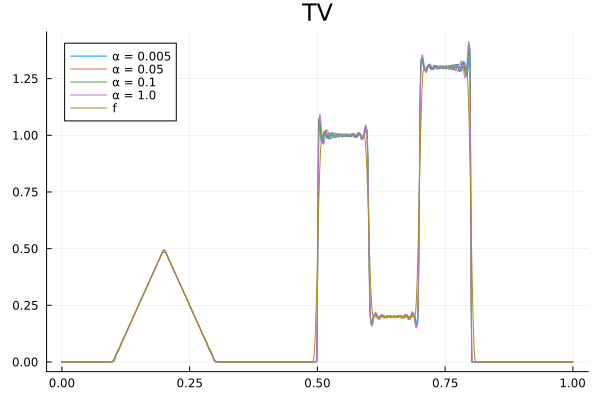

In [35]:
legend = vcat(["α = "*string(α) for α in αs[1:end-1]], ["f"])
plot(X, [f_TVs, convolved_scat], plot_title="TV", lab=permutedims(legend))

# Chapter 7 : Besov Space